In [1]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from itertools import combinations

In [12]:
CAMERA_WALL_DISTANCE = 1 # m

data_dir = Path("data")

devices = {}

for device_dir in data_dir.iterdir():
	if not device_dir.is_dir():
		continue
	print(device_dir.name)

	images = {}
	for image_dir in device_dir.glob("*.png"):
		images[image_dir.stem] = cv2.imread(str(image_dir))

	devices[device_dir.name] = images



184430100161970F00_49
1844301001978E0E00_11
1844301001D89B0F00_37
184430101147970F00_6
184430101147970F00_6_again
1844301011978E0E00_42
1844301011BD9A0F00_9
184430102161970F00_44
184430102164970F00_13
18443010219A8E0E00_29
1844301021BD9A0F00_15
1844301021E78E0E00_28
1844301031969B0F00_19
1844301031BD9A0F00_7
1844301031BD9A0F00_7_again
1844301041748E0E00_22
18443010418E8E0E00_18
1844301041969B0F00_2
1844301041969B0F00_2_again
1844301041BD9A0F00_27
1844301041CD9A0F00_41
18443010516A8E0E00_39
1844301051969B0F00_16
1844301051CD9A0F00_23
1844301051FA960F00_17
184430106117970F00_45
1844301061CD9A0F00_30
1844301061FD960F00_50
1844301071DA9A0F00_46
18443010819D8E0E00_31
1844301081C49B0F00_5
1844301081D09A0F00_3
1844301081D09A0F00_3_again
1844301081FD960F00_4
1844301081FD960F00_4_again
1844301091DD9A0F00_38
18443010A1848E0E00_21
18443010A1DD9A0F00_47
18443010B1878E0E00_48
18443010B1938E0E00_35
18443010B1D49B0F00_43
18443010C1568E0E00_52
18443010C185960F00_12
18443010C1DD9A0F00_14
18443010D18596

In [13]:
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)

def get_corners(image):
	""" Get the corners of the noise pattern board """
	
	corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(image, aruco_dict)
	inds = np.argsort(ids.flatten())
	corners_sorted = np.array(corners)[inds]
	if len(corners_sorted) != 4:
		raise Exception("Noise pattern board not found")

	center = np.array([m.mean(axis=1).flatten() for m in corners_sorted]).mean(axis=0)

	points = []
	for m in corners_sorted:
		i = np.linalg.norm(m - center, axis=-1).argmin()
		points.append(m[:, i])

	points = np.array(points).reshape(-1, 2)

	return points

def get_center(points):
	center = points.mean(axis=0)
	return center[0], center[1]

def get_rotation(points):
	center_bottom = (points[0] + points[1]) / 2
	center_top = (points[2] + points[3]) / 2
	d = center_bottom - center_top
	angle = np.arctan2(*d)
	return angle

def get_board_width(points):
	return np.linalg.norm(points[0] - points[1])
	

In [14]:
center_bottom = np.array([-4, 600])
center_top = np.array([0, 0])
d = center_bottom - center_top
angle = np.arctan2(*d)
angle_deg = np.rad2deg(angle)
print(angle_deg)

-0.3819662047290255


In [15]:
yaw = np.rad2deg(np.arctan2(offset + px2m * (img.shape[1]/2 - center_x), CAMERA_WALL_DISTANCE))
pitch =   np.rad2deg(np.arctan2(px2m * (img.shape[0]/2 - center_y), CAMERA_WALL_DISTANCE))
yaw1 = np.rad2deg(np.arctan2(offset + px2m * (img.shape[1]/2 - center_x+4), CAMERA_WALL_DISTANCE))
pitch1 =   np.rad2deg(np.arctan2(px2m * (img.shape[0]/2 - center_y+4), CAMERA_WALL_DISTANCE))

print(yaw-yaw1, pitch-pitch1)

-0.28382917877954794 -0.28463569046923154


angle: -0.5894419550895691
center: [[667.25 402.  ]]
width: 484.02581787109375 px; 1cm = 8.06709696451823px


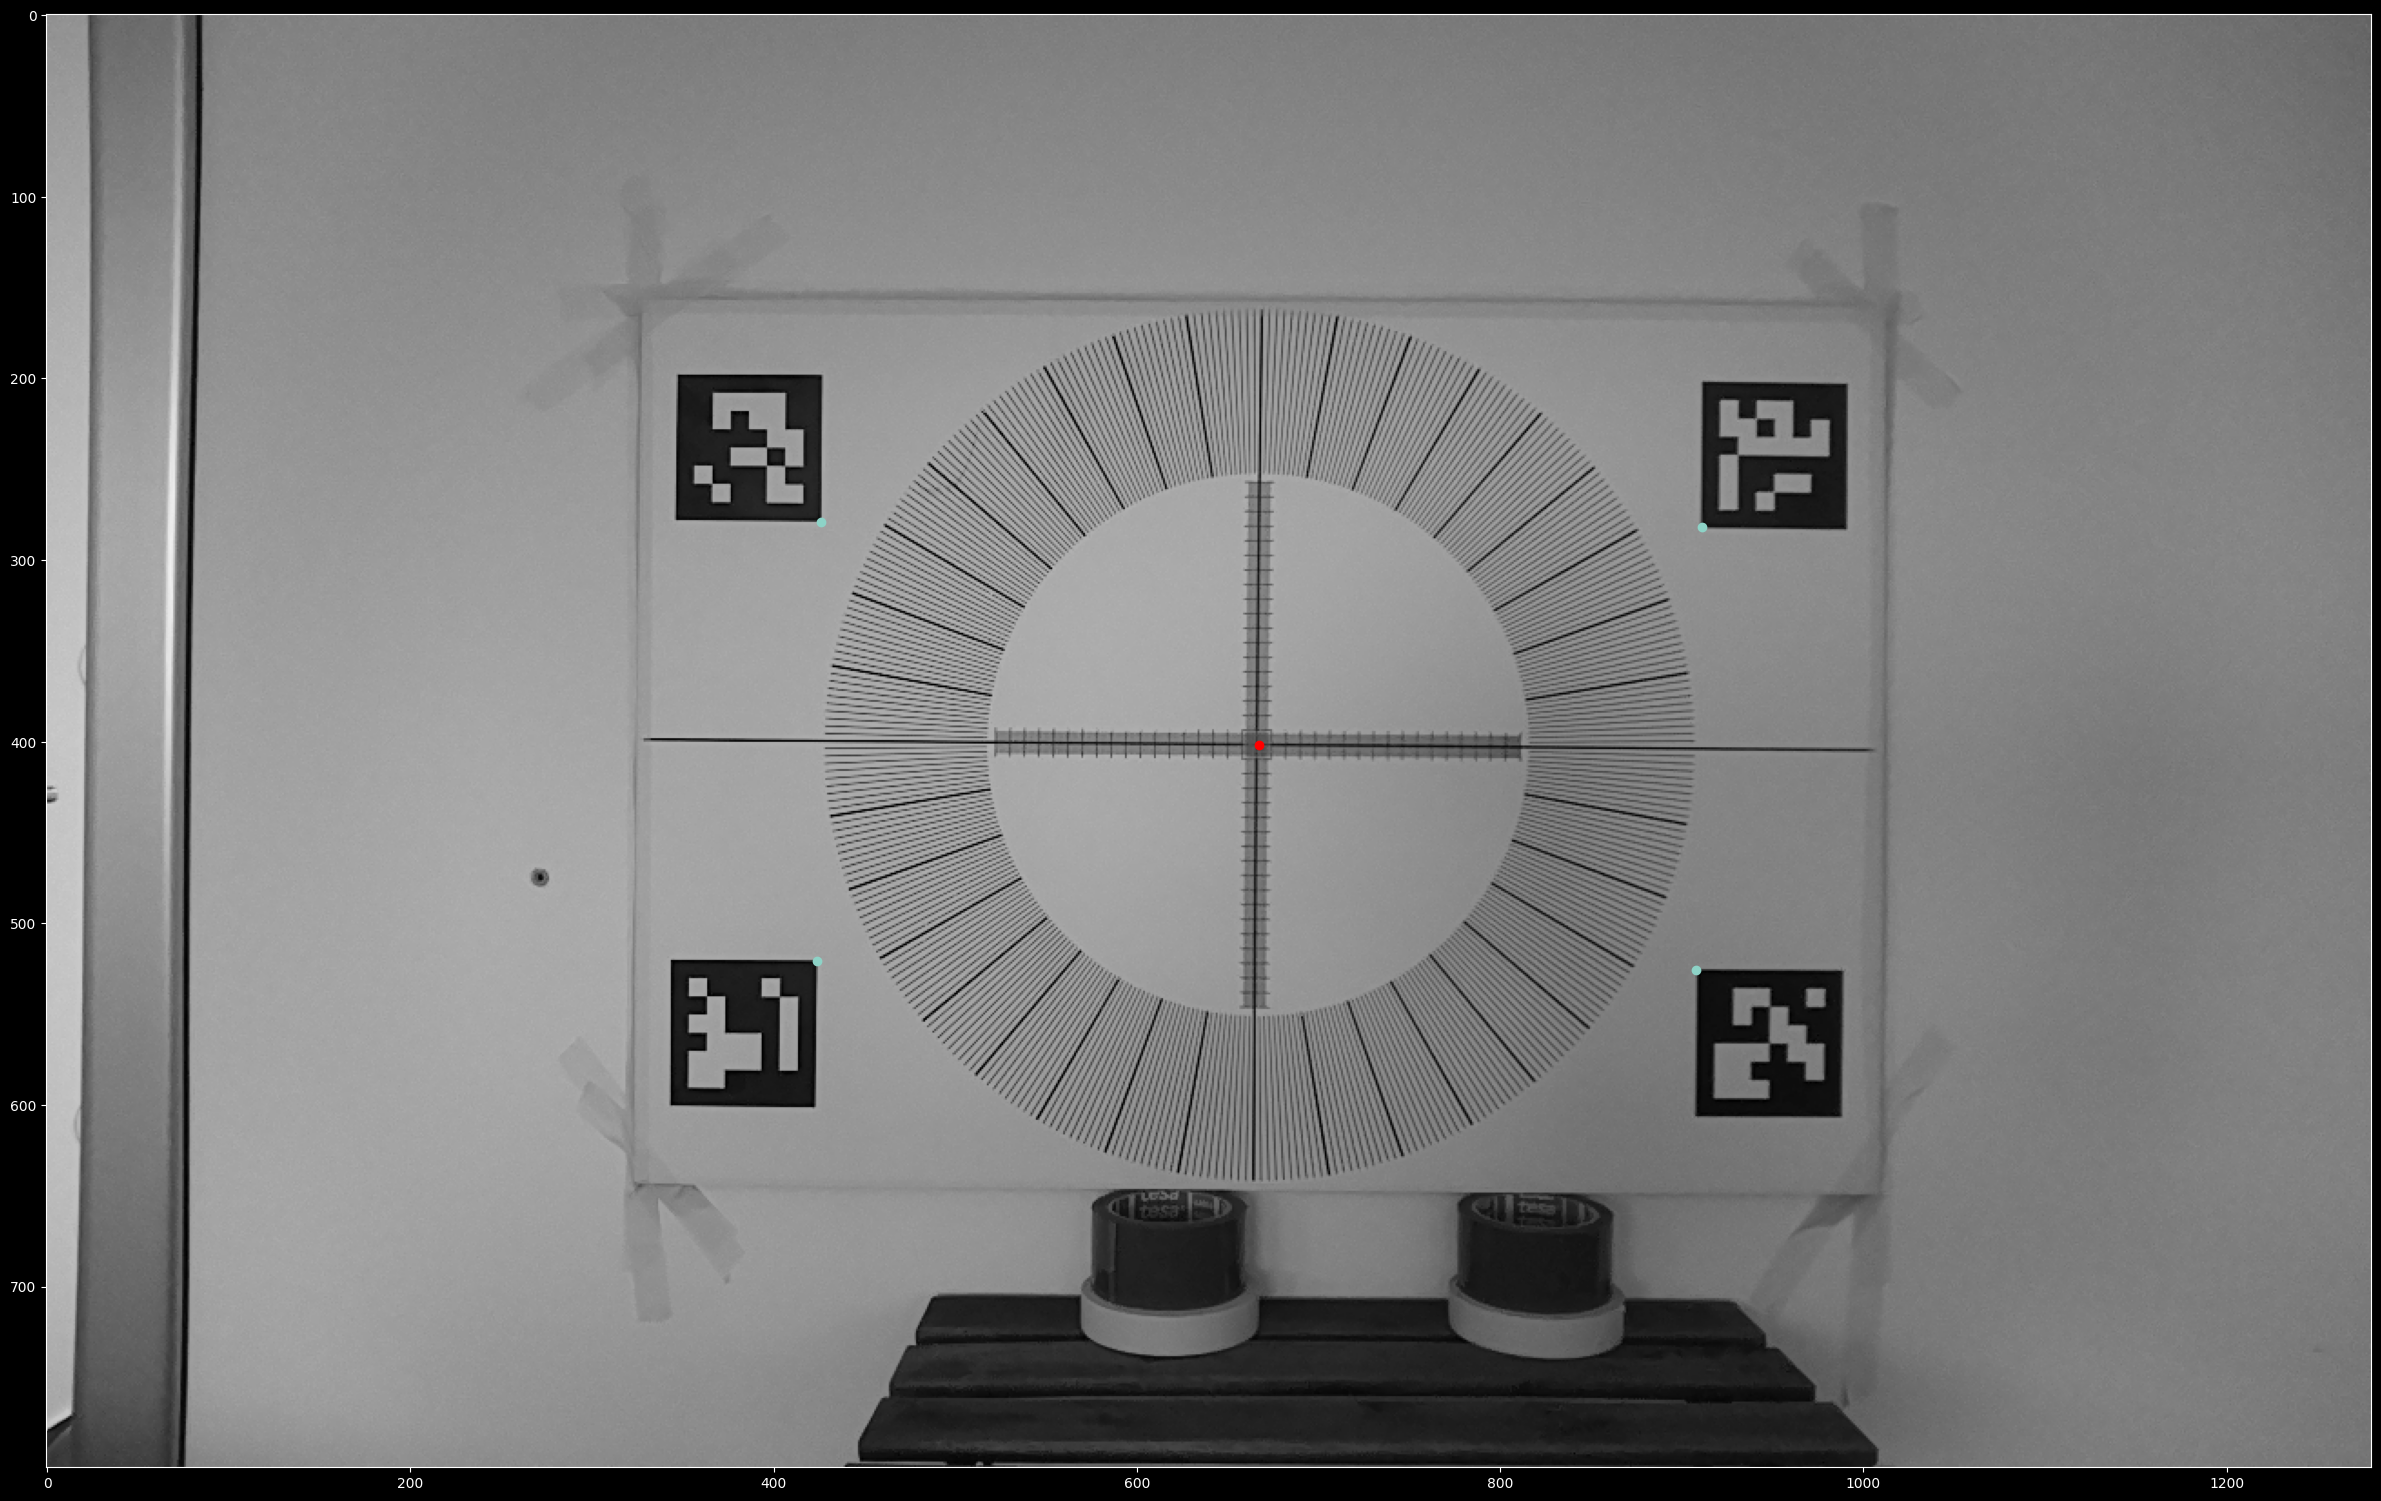

In [16]:
img = [*devices.values()][0]["rectified_left"]

img = devices["1844301031BD9A0F00_7"]["left"]

points = get_corners(img)

center = points.mean(axis=0).reshape((-1, 2))

plt.figure(figsize=(30,20))
plt.imshow(img)
plt.scatter(points[:, 0], points[:, 1])
k = 3
plt.scatter(center[:, 0], center[:, 1], c="r")

print(f"angle: {np.rad2deg(get_rotation(points))}")
print(f"center: {center}")

board_width = get_board_width(points)
print(f"width: {board_width} px; 1cm = {board_width/60}px")

In [28]:
results = []

offsets = { # compensation for different camera positions (in m)
    "right": -0.0375,
    "rectified_right": -0.0375,
    "color": 0,
    "left": 0.0375,
    "rectified_left": 0.0375,
}

for mxid, images in devices.items():
    result = {"mxid": mxid}

    for name, img in images.items():
        points = get_corners(img)
        center_x, center_y = get_center(points)
        angle = get_rotation(points)
        board_width = get_board_width(points)
        px2m = 0.6 / board_width

        offset = offsets[name]

        result[f"{name}_roll_angle"] = np.rad2deg(angle)
        result[f"{name}_yaw_angle"] = np.rad2deg(np.arctan2(offset + px2m * (img.shape[1]/2 - center_x), CAMERA_WALL_DISTANCE))
        result[f"{name}_pitch_angle"] = np.rad2deg(np.arctan2(px2m * (img.shape[0]/2 - center_y), CAMERA_WALL_DISTANCE))


    for cam_a, cam_b in combinations(["left", "right", "color"], 2):
        result[f"{cam_a}_{cam_b}_roll_diff"] = np.abs(result[f"{cam_a}_roll_angle"] - result[f"{cam_b}_roll_angle"])
        result[f"{cam_a}_{cam_b}_yaw_diff"] = np.abs(result[f"{cam_a}_yaw_angle"] - result[f"{cam_b}_yaw_angle"])
        result[f"{cam_a}_{cam_b}_pitch_diff"] = np.abs(result[f"{cam_a}_pitch_angle"] - result[f"{cam_b}_pitch_angle"])

    for cam_a, cam_b in combinations(["rectified_left", "rectified_right"], 2):
        result[f"{cam_a}_{cam_b}_roll_diff"] = np.abs(result[f"{cam_a}_roll_angle"] - result[f"{cam_b}_roll_angle"])
        result[f"{cam_a}_{cam_b}_yaw_diff"] = np.abs(result[f"{cam_a}_yaw_angle"] - result[f"{cam_b}_yaw_angle"])
        result[f"{cam_a}_{cam_b}_pitch_diff"] = np.abs(result[f"{cam_a}_pitch_angle"] - result[f"{cam_b}_pitch_angle"])

    results.append(result)

results_df = pd.DataFrame(results)
results_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
mxid,184430100161970F00_49,1844301001978E0E00_11,1844301001D89B0F00_37,184430101147970F00_6,184430101147970F00_6_again,1844301011978E0E00_42,1844301011BD9A0F00_9,184430102161970F00_44,184430102164970F00_13,18443010219A8E0E00_29,...,18443010E185960F00_8,18443010E188960F00_1,18443010E188960F00_1_again,18443010E1A08E0E00_26,18443010E1D79B0F00_20,18443010F160970F00_51,18443010F177970F00_24,18443010F1A38E0E00_33,18443010F1AD8E0E00_40,19443010C124C92600_34
color_roll_angle,-0.460567,-0.185123,0.046206,-0.414512,-0.414512,-0.184378,-0.13873,0.046281,-0.32318,0.184527,...,0.690277,0.183053,0.276566,0.0,-0.091967,-0.36905,0.230844,0.04591,-0.276566,0.368753
color_yaw_angle,0.193906,1.375383,-0.6739,1.391694,1.391701,0.997953,1.243452,0.993426,1.156368,0.860753,...,1.595355,1.294437,1.218659,1.345439,1.588583,1.024002,0.771141,1.418261,1.508152,0.898732
color_pitch_angle,-0.318558,0.125059,0.375173,0.498603,0.512455,0.131687,0.06253,-0.305697,-0.644026,0.61088,...,-0.21415,0.330547,0.339333,-0.104048,0.497411,0.055357,0.604422,-0.484372,-1.404423,1.071528
left_roll_angle,0.118135,0.0,0.0,-0.23627,-0.117892,-0.235784,0.0,0.0,-0.235784,0.118625,...,0.118625,-0.237248,-0.23774,0.0,-0.355135,0.0,-0.117892,-0.826892,-0.117892,0.118135
left_yaw_angle,1.775896,-0.378106,1.225043,0.582728,0.568207,-0.180867,0.831801,2.076655,0.163917,-0.37075,...,-0.656609,-0.342477,-0.383331,-0.286771,-1.185561,-0.561647,2.05892,1.209332,0.394275,-0.946002
left_pitch_angle,-0.903663,0.106762,-1.047544,-0.231317,-0.213082,0.105884,0.409248,-0.479423,0.708776,-1.232682,...,-1.375549,-2.755846,-2.814949,-1.570241,-1.746857,-0.089153,-0.497181,-0.58469,-0.921376,-1.39675
rectified_left_roll_angle,0.355135,0.355135,0.11838,0.117892,0.117892,0.0,0.355135,0.118135,0.353673,0.35587,...,0.237248,0.355135,0.35587,0.47156,0.23627,0.118625,0.23627,0.235784,0.234817,0.23627
rectified_left_yaw_angle,2.767909,0.03118,1.384779,0.493767,0.493767,0.624621,0.814034,2.059104,0.323455,0.165314,...,0.576245,-0.039994,-0.080195,-0.044168,-1.424586,-0.360318,2.041188,0.90554,0.376567,0.589211
rectified_left_pitch_angle,-0.852242,0.035587,-0.923274,-0.213523,-0.213523,0.0,0.676117,-0.478434,0.673319,-0.982608,...,-1.411236,-2.738094,-2.761555,-1.414396,-1.661199,-0.017794,-0.443906,-0.319619,-0.850507,-1.222495


In [19]:
results_df[["right_color_roll_diff", "right_color_yaw_diff", "right_color_pitch_diff"]].mean()

right_color_roll_diff     0.291321
right_color_yaw_diff      1.208002
right_color_pitch_diff    0.936009
dtype: float64

In [20]:
results_df.std(numeric_only=True)

color_roll_angle               0.253074
color_yaw_angle                0.561639
color_pitch_angle              0.668004
left_roll_angle                0.216427
left_yaw_angle                 1.281445
left_pitch_angle               0.869811
rectified_left_roll_angle      0.133990
rectified_left_yaw_angle       1.148356
rectified_left_pitch_angle     0.849564
rectified_right_roll_angle     0.141166
rectified_right_yaw_angle      1.152783
rectified_right_pitch_angle    0.853842
right_roll_angle               0.237874
right_yaw_angle                1.083821
right_pitch_angle              0.800248
left_right_roll_diff           0.180412
left_right_yaw_diff            1.258521
left_right_pitch_diff          0.826578
left_color_roll_diff           0.235712
left_color_yaw_diff            1.063703
left_color_pitch_diff          0.860307
right_color_roll_diff          0.196235
right_color_yaw_diff           0.768218
right_color_pitch_diff         0.691562
dtype: float64

In [21]:
np.mean(np.abs(results_df["color_roll_angle"].to_numpy()))

0.20547977

In [22]:
mount_roll_angle = np.mean([
	np.mean(results_df["color_roll_angle"].to_numpy()),
	np.mean(results_df["left_roll_angle"].to_numpy()),
	np.mean(results_df["right_roll_angle"].to_numpy())
])

mount_yaw_angle = np.mean([
	np.mean(results_df["color_yaw_angle"].to_numpy()),
	np.mean(results_df["left_yaw_angle"].to_numpy()),
	np.mean(results_df["right_yaw_angle"].to_numpy())
])

mount_pitch_angle = np.mean([
	np.mean(results_df["color_pitch_angle"].to_numpy()),
	np.mean(results_df["left_pitch_angle"].to_numpy()),
	np.mean(results_df["right_pitch_angle"].to_numpy())
])

print(f"mount_roll_angle: {mount_roll_angle}")
print(f"mount_yaw_angle: {mount_yaw_angle}")
print(f"mount_pitch_angle: {mount_pitch_angle}")

results_corrected = results_df.copy()
results_corrected["color_roll_angle"] -= mount_roll_angle
results_corrected["left_roll_angle"] -= mount_roll_angle
results_corrected["right_roll_angle"] -= mount_roll_angle
results_corrected["rectified_right_roll_angle"] -= mount_roll_angle
results_corrected["rectified_left_roll_angle"] -= mount_roll_angle

results_corrected["color_yaw_angle"] -= mount_yaw_angle
results_corrected["left_yaw_angle"] -= mount_yaw_angle
results_corrected["right_yaw_angle"] -= mount_yaw_angle
results_corrected["rectified_right_yaw_angle"] -= mount_yaw_angle
results_corrected["rectified_left_yaw_angle"] -= mount_yaw_angle

results_corrected["color_pitch_angle"] -= mount_pitch_angle
results_corrected["left_pitch_angle"] -= mount_pitch_angle
results_corrected["right_pitch_angle"] -= mount_pitch_angle
results_corrected["rectified_right_pitch_angle"] -= mount_pitch_angle
results_corrected["rectified_left_pitch_angle"] -= mount_pitch_angle



mount_roll_angle: -0.1331244260072708
mount_yaw_angle: 0.9585752530071376
mount_pitch_angle: -0.4121717596609223


In [23]:
results_corrected["color_roll_angle_ok"] = np.abs(results_corrected["color_roll_angle"]) < 0.5
results_corrected["color_yaw_angle_ok"] = np.abs(results_corrected["color_yaw_angle"]) < 1.0
results_corrected["color_pitch_angle_ok"] = np.abs(results_corrected["color_pitch_angle"]) < 1.2

results_corrected["left_roll_angle_ok"] = np.abs(results_corrected["left_roll_angle"]) < 0.5
results_corrected["left_yaw_angle_ok"] = np.abs(results_corrected["left_yaw_angle"]) < 2.0
results_corrected["left_pitch_angle_ok"] = np.abs(results_corrected["left_pitch_angle"]) < 1.5

results_corrected["rectified_right_roll_angle_ok"] = np.abs(results_corrected["rectified_right_roll_angle"]) < 0.5
results_corrected["rectified_right_yaw_angle_ok"] = np.abs(results_corrected["rectified_right_yaw_angle"]) < 2.0
results_corrected["rectified_right_pitch_angle_ok"] = np.abs(results_corrected["rectified_right_pitch_angle"]) < 1.5

results_corrected["rectified_left_roll_angle_ok"] = np.abs(results_corrected["rectified_left_roll_angle"]) < 0.5
results_corrected["rectified_left_yaw_angle_ok"] = np.abs(results_corrected["rectified_left_yaw_angle"]) < 2.0
results_corrected["rectified_left_pitch_angle_ok"] = np.abs(results_corrected["rectified_left_pitch_angle"]) < 1.5

results_corrected["right_roll_angle_ok"] = np.abs(results_corrected["right_roll_angle"]) < 0.5
results_corrected["right_yaw_angle_ok"] = np.abs(results_corrected["right_yaw_angle"]) < 2.0
results_corrected["right_pitch_angle_ok"] = np.abs(results_corrected["right_pitch_angle"]) < 1.5


# results_corrected["left_right_roll_diff_ok"] = results_corrected["left_right_roll_diff"] < 0.3
# results_corrected["left_right_yaw_diff_ok"] = results_corrected["left_right_yaw_diff"] < 0.8
# results_corrected["left_right_pitch_diff_ok"] = results_corrected["left_right_pitch_diff"] < 0.15



In [26]:
results_corrected.transpose().to_excel("results.xlsx")

In [27]:
list(combinations([1,2,3], r=2))

[(1, 2), (1, 3), (2, 3)]